## Initial Setup

In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error
from doubleml import DoubleMLData, DoubleMLPLR
from sklearn.model_selection import KFold
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.base import clone
import doubleml as dml
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [112]:
# Assigning the current directory to this_dir
from pathlib import Path
this_dir = Path (".")

# make it absolute
print(this_dir.resolve())


C:\Users\Anna\research_module\RM-project


## Data Creation

All used datasets arre taken form official web-site of Euro Union statistics: https://ec.europa.eu/eurostat/databrowser/explore/all/all_themes

After implying the path to our data using *Path*, which ensuring better code readability and portability, we can start to collect data files, correct them with the list of selected countries* and make long format to make it more convinient for Machine Learning.

*These countries mostly have no NA values in all datasets. However, there were some correction for 3 countries:
In dataset related to percentage of not EU migrants:
- For Croatia and Hungary the 0.1 was placed in the beggining
- For Serbian the average value of 2023 and 2021 was placed in 2022

In dataset related to municipal waste per capita:
- For Ireland the average was taken for 2015
- Total municipal wastes for 2 last years were taken from here https://www.cso.ie/en/releasesandpublications/ep/p-eii/environmentalindicatorsireland2023/waste/#:~:text=Municipal%20waste%20generated%20in%20Ireland%20was%203.2%20million%20tonnes%20in,kilogrammes%20per%20capita%20in%202021 and waste per capita was calculated depending on Ireland population.

In [113]:
selected_countries = ["Belgium", "Austria", "Czechia", "Ireland", "Cyprus", "Hungary", "Serbia", "Switzerland", 
                       "Sweden", "Denmark", "France", "Spain", "Netherlands", "Norway", "Germany", "Italy",
                       "Poland", "Lithuania", "Luxembourg", "Portugal", "Latvia", "Malta", 
                       "Slovenia", "Estonia", "Finland", "Croatia", "Greece"]

### Policy

I will start with the Policy dataset, where for countries that approved a policy named "The Global Compact for Safe, Orderly and Regular Migration (GCM)" in a 2018, a value of 1 will be assigned from that year onwards. If no policy was applied (or countries were forced to sign it or there were debates, e.g. Switzerland, Denmark), the value will be 0. These policies include advices and recommendations that make it easier for migrants from non-EU countries to integrate.


In [114]:
data_file_p = this_dir / "data" / "policy.xlsx"
data_file_p.resolve()
df_policy = pd.read_excel(data_file_p, sheet_name="Sheet1")

from help_func import convert_to_long_format
# Converting into long format
df_policy_long = convert_to_long_format(df_policy, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='Policy')

print(df_policy_long)

         Country  Year  Policy
0        Belgium  2014       0
1        Czechia  2014       0
2        Denmark  2014       0
3        Germany  2014       0
4        Estonia  2014       0
..           ...   ...     ...
238      Finland  2022       0
239       Sweden  2022       1
240       Norway  2022       1
241  Switzerland  2022       0
242       Serbia  2022       1

[243 rows x 3 columns]


### Municipal Wastes

Afterwards, I will move on to the data on municipal waste, which is measured in kilograms per capita. 

Municipal waste refers to waste generated by households, as well as small businesses and institutions, that is collected by or on behalf of municipalities. It typically includes waste from residential areas, street cleaning, and similar sources.

In [115]:
data_file_w = this_dir / "data" / "env_waste_mun.xlsx"
data_file_w.resolve()
data_was = pd.read_excel(data_file_w, sheet_name="Sheet 1", na_values=':')
data_was = data_was.rename(columns={"TIME": "Country"})

In [116]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

filtered_data_was = data_was[data_was["Country"].isin(selected_countries)]

from help_func import convert_to_long_format

filtered_data_was_long = convert_to_long_format(filtered_data_was, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='waste_per_cap')

print(filtered_data_was_long)

         Country  Year  waste_per_cap
0        Belgium  2013          436.0
1        Czechia  2013          307.0
2        Denmark  2013          813.0
3        Germany  2013          615.0
4        Estonia  2013          293.0
..           ...   ...            ...
265      Finland  2022          522.0
266       Sweden  2022          395.0
267       Norway  2022          768.0
268  Switzerland  2022          677.0
269       Serbia  2022          473.0

[270 rows x 3 columns]


I will analyze this variable in more detail, so we need data for all years from 2013 to 2022 (later, due to the limitations of some datasets, data from 2015 to 2022 will be used). It will start with analysis unexpected outliers in waste growth for any given year.

<Axes: xlabel='Year'>

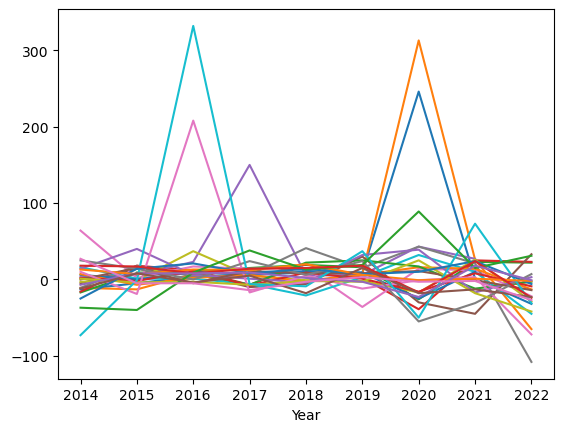

In [117]:
plottable = filtered_data_was_long.pivot(columns=['Country'], index='Year')
diff = plottable.diff()
diff.plot(legend=False)

As we can see there are 4 extremely high surge for 4 different countries in 2 years. The most appropriate explanation is that for these countries methodology for waste accounting was changed, because first, after the surge, waste levels returned to a normal level, and second, only specific countries experienced this effect.
Now I will find which countries they are.

<Axes: xlabel='Year'>

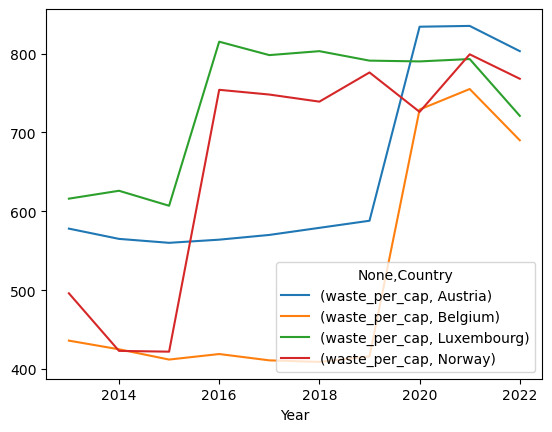

In [118]:
plottable.loc[:, diff.max() > 200].plot()

In [119]:
# repair waste data for Austria, Belgium, Norway, Luxembourg before the following years:
repairs = [('Austria', 2020), ('Belgium', 2020), ('Norway', 2016), ('Luxembourg', 2016)] 

I was considering 3 option; all of them are described below. The most fair option is to leave recent data (for which new methodology was used) for these countries.


We can do this without worrying about the balance of the dataset because:

- There are no specific countries defined for our analysis: we simply have observations with a certain set of factors;

- Time is also not a factor in our analysis; we are only looking at a specific set of data for each observation;

- We do not consider the change of waste generation (we look at the absolute value), and we do not care how the amount of waste has changed compared to the previous year;

- Each value does not depend on the previous one (which is the definition of time dependency), meaning the process is stationary.

In [120]:
# Option 1
# Leave only more recent data (with higher levels) asuming it was collected with improved methodology

fdwl = filtered_data_was_long
for country, first_correct_yr in repairs:
    fdwl.drop(fdwl[(fdwl.Country == country) & (fdwl.Year < first_correct_yr)].index, inplace=True)

# ensure, for example, that Austria lost all years before 2020 
filtered_data_was_long[filtered_data_was_long.Country == 'Austria']

,Country,Year,waste_per_cap
207,Austria,2020,834.0
234,Austria,2021,835.0
261,Austria,2022,803.0


<Axes: xlabel='Year'>

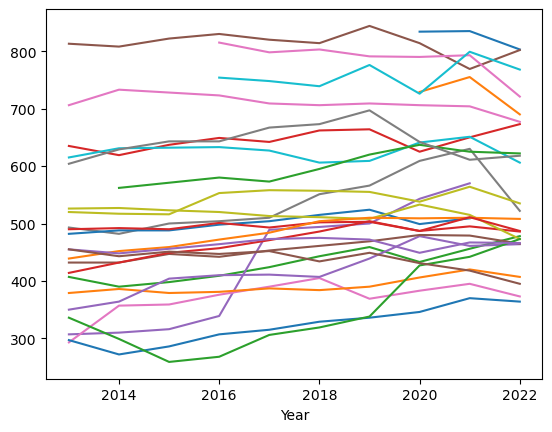

In [121]:
filtered_data_was_long.pivot(columns=['Country'], index='Year').plot(legend=False)

### Covariates

Lastly, we will perform the same manipulations with data reading for our covariates:

- Environmental tax in percent of GDP: Economic regulations can influence waste production.
- Unemployment in percent of labour force: Reflects the economic condition of a country.
- Real spending per capita: Consumer behavior is linked to the amount of waste generated.
- Urbanization rate: Urbanization usually leads to an increase in waste.

#### Environmental Taxes

In [122]:
data_file_t = this_dir / "data" / "env_tax_gdp_per.xlsx"
data_file_t.resolve()
data_etax = pd.read_excel(data_file_t, sheet_name="Sheet 1")
data_etax = data_etax.rename(columns={"TIME": "Country"})

filtered_data_etax = data_etax[data_etax["Country"].isin(selected_countries)]

In [123]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_etax_long = convert_to_long_format(filtered_data_etax, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='env_tax')
print(filtered_data_etax_long)

         Country  Year env_tax
0        Belgium  2014    2.54
1        Czechia  2014    2.12
2        Denmark  2014       4
3        Germany  2014    1.99
4        Estonia  2014    2.66
..           ...   ...     ...
229     Slovenia  2022    2.87
230      Finland  2022    2.43
231       Sweden  2022    1.91
232       Norway  2022    1.29
233  Switzerland  2022    1.27

[234 rows x 3 columns]


#### Unemployment

In [124]:
data_file_u = this_dir / "data" / "unemp_percent.xlsx"
data_file_u.resolve()
data_unemp = pd.read_excel(data_file_u, sheet_name="Sheet 1")
data_unemp = data_unemp.rename(columns={"TIME": "Country"})

filtered_data_unemp = data_unemp[data_unemp["Country"].isin(selected_countries)]
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[1:2], axis=1)
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[-1], axis=1)


In [125]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_unemp_long = convert_to_long_format(filtered_data_unemp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='unemp_rate')


print(filtered_data_unemp_long)

         Country  Year unemp_rate
0        Belgium  2015        8.7
1        Czechia  2015        5.1
2        Denmark  2015        6.3
3        Germany  2015        4.4
4        Estonia  2015        6.4
..           ...   ...        ...
211      Finland  2022        6.8
212       Sweden  2022        7.5
213       Norway  2022        3.2
214  Switzerland  2022        4.1
215       Serbia  2022        9.6

[216 rows x 3 columns]


#### Real Expenditures

In [126]:
data_file_e = this_dir / "data" / "real_exp_pc.xlsx"
data_file_e.resolve()
data_exp = pd.read_excel(data_file_e, sheet_name="Sheet 1")
data_exp = data_exp.rename(columns={"TIME": "Country"})

filtered_data_exp = data_exp[data_exp["Country"].isin(selected_countries)]
filtered_data_exp = filtered_data_exp.drop(filtered_data_exp.columns[-1], axis=1)


In [127]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_exp_long = convert_to_long_format(filtered_data_exp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='rexp_per_cap')

print(filtered_data_exp_long)

         Country  Year rexp_per_cap
0        Belgium  2014        21300
1        Czechia  2014        14500
2        Denmark  2014        21400
3        Germany  2014        22500
4        Estonia  2014        12700
..           ...   ...          ...
238      Finland  2022        25500
239       Sweden  2022        26000
240       Norway  2022        29700
241  Switzerland  2022        27300
242       Serbia  2022        12300

[243 rows x 3 columns]


#### Urbanization

In [128]:
data_file_ur = this_dir / "data" / "p_urbanization.xlsx"
data_file_ur.resolve()
data_urb = pd.read_excel(data_file_ur, sheet_name="Data")
data_urb = data_urb.rename(columns={"TIME": "Country"})

filtered_data_urb = data_urb[data_urb["Country"].isin(selected_countries)]


In [129]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_urb_long = convert_to_long_format(filtered_data_urb, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='urb_ind')

print(filtered_data_urb_long)

         Country  Year  urb_ind
0        Belgium  2014   97.833
1        Denmark  2014   87.410
2        Germany  2014   77.190
3        Estonia  2014   68.269
4         Sweden  2014   86.247
..           ...   ...      ...
238      Hungary  2022   72.552
239       Serbia  2022   56.873
240  Switzerland  2022   74.092
241       Norway  2022   83.664
242       Greece  2022   80.357

[243 rows x 3 columns]


### Merging

In [130]:
# Merging tables on the columns 'Country' and 'Year'
df_combined1 = pd.merge(filtered_data_was_long, df_policy_long,
                       on=['Country', 'Year'], how='inner')

# Adding other covariates in a similar way
df_combined2 = pd.merge(df_combined1, filtered_data_etax_long, on=['Country', 'Year'], how='inner')
df_combined3 = pd.merge(df_combined2, filtered_data_unemp_long, on=['Country', 'Year'], how='inner')
df_combined4 = pd.merge(df_combined3, filtered_data_exp_long, on=['Country', 'Year'], how='inner')
df = pd.merge(df_combined4, filtered_data_urb_long, on=['Country', 'Year'], how='inner')

df['waste_per_cap'] = pd.to_numeric(df['waste_per_cap'], errors='coerce')

print(df)


         Country  Year  waste_per_cap  Policy env_tax unemp_rate rexp_per_cap  \
0        Czechia  2015          316.0       0    2.05        5.1        14800   
1        Denmark  2015          822.0       0    3.97        6.3        21800   
2        Germany  2015          632.0       0    1.92        4.4        22800   
3        Estonia  2015          359.0       0    2.73        6.4        13300   
4        Ireland  2015          571.0       0    1.89        9.9        17800   
..           ...   ...            ...     ...     ...        ...          ...   
191     Slovenia  2022          487.0       1    2.87          4        20200   
192      Finland  2022          522.0       0    2.43        6.8        25500   
193       Sweden  2022          395.0       1    1.91        7.5        26000   
194       Norway  2022          768.0       1    1.29        3.2        29700   
195  Switzerland  2022          677.0       0    1.27        4.1        27300   

     urb_ind  
0     73.477

In [133]:
# Create feature 'Group': 1 if a country has ever adopted 'Policy' , 0 - never adopted 'Policy' 
new_cols = list(df.columns)
new_cols.insert(4, 'Group')
policy_per_country = df.groupby('Country')['Policy'].max()
df['Group'] = df['Country'].map(policy_per_country)
df = df[new_cols]

In [134]:
# Preview example of df
df[df.Country.isin(['Croatia', 'Denmark'])]

,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
1,Denmark,2015,822.0,0,0,3.97,6.3,21800,87.526
8,Croatia,2015,398.0,0,1,4.21,16.2,11600,56.155
23,Denmark,2016,830.0,0,0,3.91,6,21800,87.642
30,Croatia,2016,409.0,0,1,4.31,13,12100,56.403
47,Denmark,2017,820.0,0,0,3.67,5.8,22700,87.757
54,Croatia,2017,424.0,0,1,4.33,11.1,12700,56.667
71,Denmark,2018,814.0,0,0,3.62,5.1,23500,87.874
78,Croatia,2018,443.0,1,1,4.36,8.3,13300,56.947
95,Denmark,2019,844.0,0,0,3.3,5,23700,87.994
102,Croatia,2019,459.0,1,1,4.24,6.6,13900,57.242


In [135]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data.xlsx"
df.to_excel(output_file, index=False)

## Data Analysis and Preprocessing

After setting the dataset with which I am planning to work we should build graphs and see the relations between Waste and type of Policy for our 2 groups of countries. 


<Figure size 1000x600 with 0 Axes>

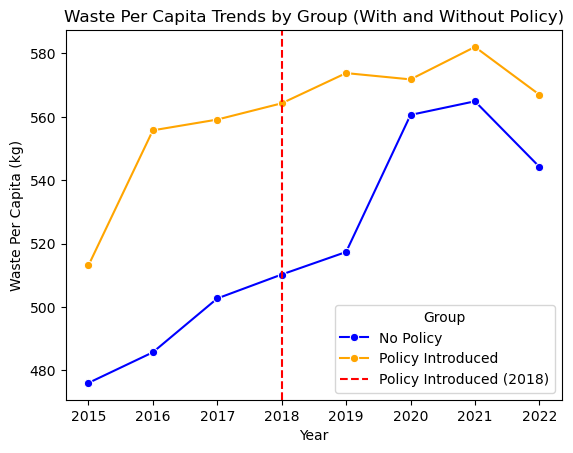

In [136]:

# Аggregation
avg_trends_waste = df.groupby(['Year', 'Group'])['waste_per_cap'].mean().reset_index()


# Graph 1: Waste Per Capita
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', hue='Group', 
             palette=["blue", "orange"], marker="o")

plt.axvline(2018, color='red', linestyle='--', label='Policy Introduced (2018)')
plt.title('Waste Per Capita Trends by Group (With and Without Policy)')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'No Policy'
labels[1] = 'Policy Introduced'
plt.legend(title='Group', handles=handles, labels=labels)
plt.show()


Conclusion: There is a tendency in attitude to migration for countries who were willing to sign the document and who - not. I am assuming that each country's decision is based on their general migration policy which is stay the same from the beggining. 
Now I will switch from problem related to finding ATE of implepenting Policy in a particular year to problem related to finding ATE of having such type of Policy during several years.

NB. The adoption of the policy does not lead to an impact, as these changes will not show the effect within our short observation period. The fact that the policy exists classifies a country into a certain group.

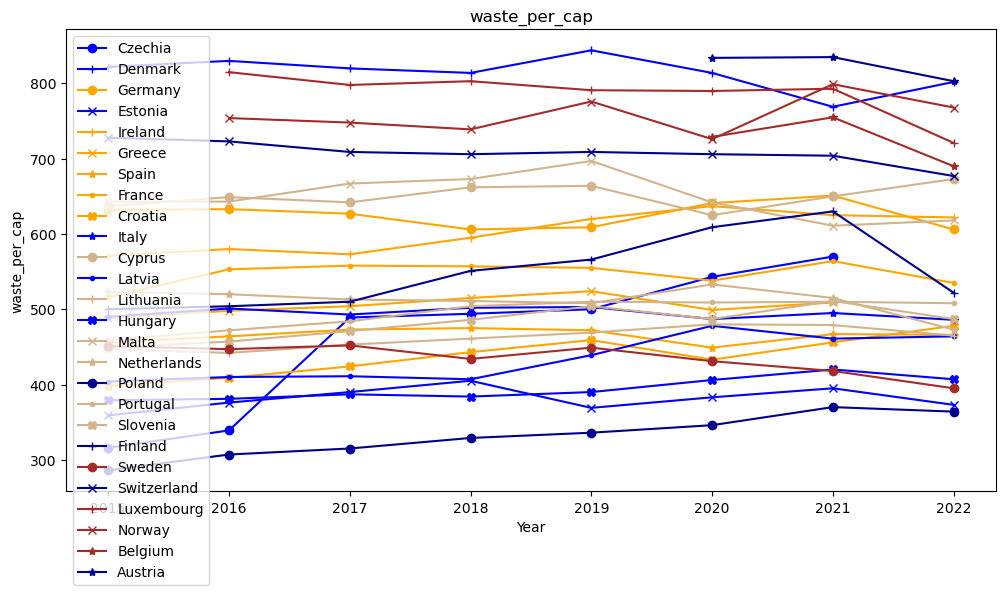

In [ ]:
# Graph of waste per year for each country

countries = df["Country"].unique()
plt.figure(figsize=(12, 6))

policy_colors_markers = itertools.cycle(itertools.product(('orange', 'tan', 'brown'), ('o', '+', 'x', '*', '.', 'X')))
no_policy_colors_markers = itertools.cycle(itertools.product(('blue', 'darkblue', 'cornflowerblue'), ('o', '+', 'x', '*', '.', 'X')))

y = 'waste_per_cap'
x = 'Year'
for country in countries:
    subset = df[df["Country"] == country]
    #color = "orange" if subset["Policy"].iloc[0] == 1 else "blue" 
    if  subset["Group"].iloc[0] == 1:
        color, marker = next(policy_colors_markers)
    else:
        color, marker = next(no_policy_colors_markers)
    plt.plot(subset[x], subset[y], marker=marker, label=country, color=color)

plt.xlabel(x)
plt.ylabel(y)
plt.title(y)
plt.legend()
plt.show()

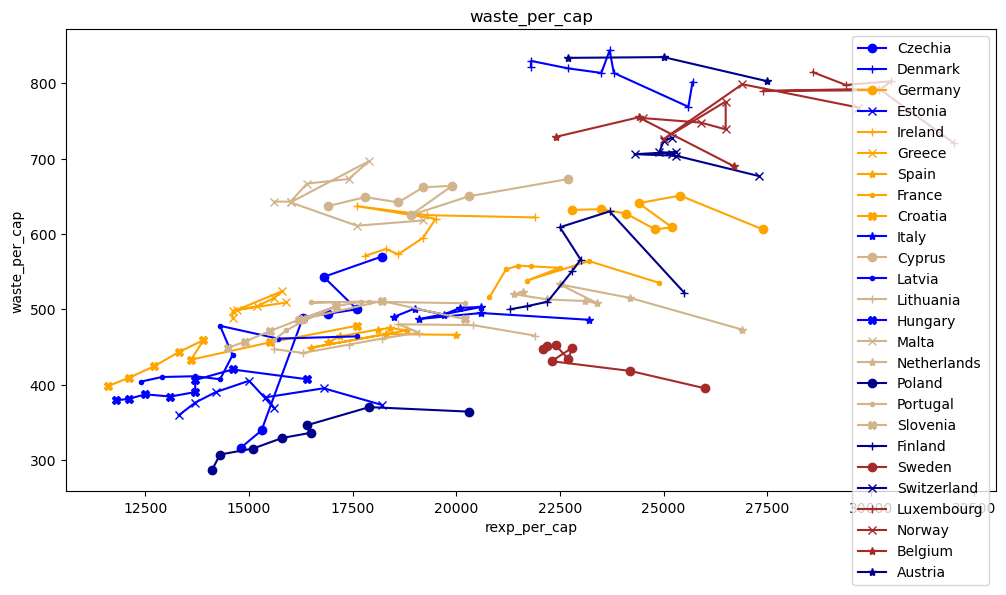

In [138]:
# Graph of relation of waste per capita and real expenditure per capita for each country

countries = df["Country"].unique()
plt.figure(figsize=(12, 6))

policy_colors_markers = itertools.cycle(itertools.product(('orange', 'tan', 'brown'), ('o', '+', 'x', '*', '.', 'X')))
no_policy_colors_markers = itertools.cycle(itertools.product(('blue', 'darkblue', 'cornflowerblue'), ('o', '+', 'x', '*', '.', 'X')))

x = "rexp_per_cap"
y = "waste_per_cap"
for country in countries:
    subset = df[df["Country"] == country]
    #color = "orange" if subset["Policy"].iloc[0] == 1 else "blue"  # Оранжевый = Policy 1, Синий = Policy 0
    if  subset["Group"].iloc[0] == 1:
        color, marker = next(policy_colors_markers)
    else:
        color, marker = next(no_policy_colors_markers)
    plt.plot(subset[x], subset[y], marker=marker, label=country, color=color)

plt.xlabel(x)
plt.ylabel(y)
plt.title(y)
plt.legend()
plt.show()

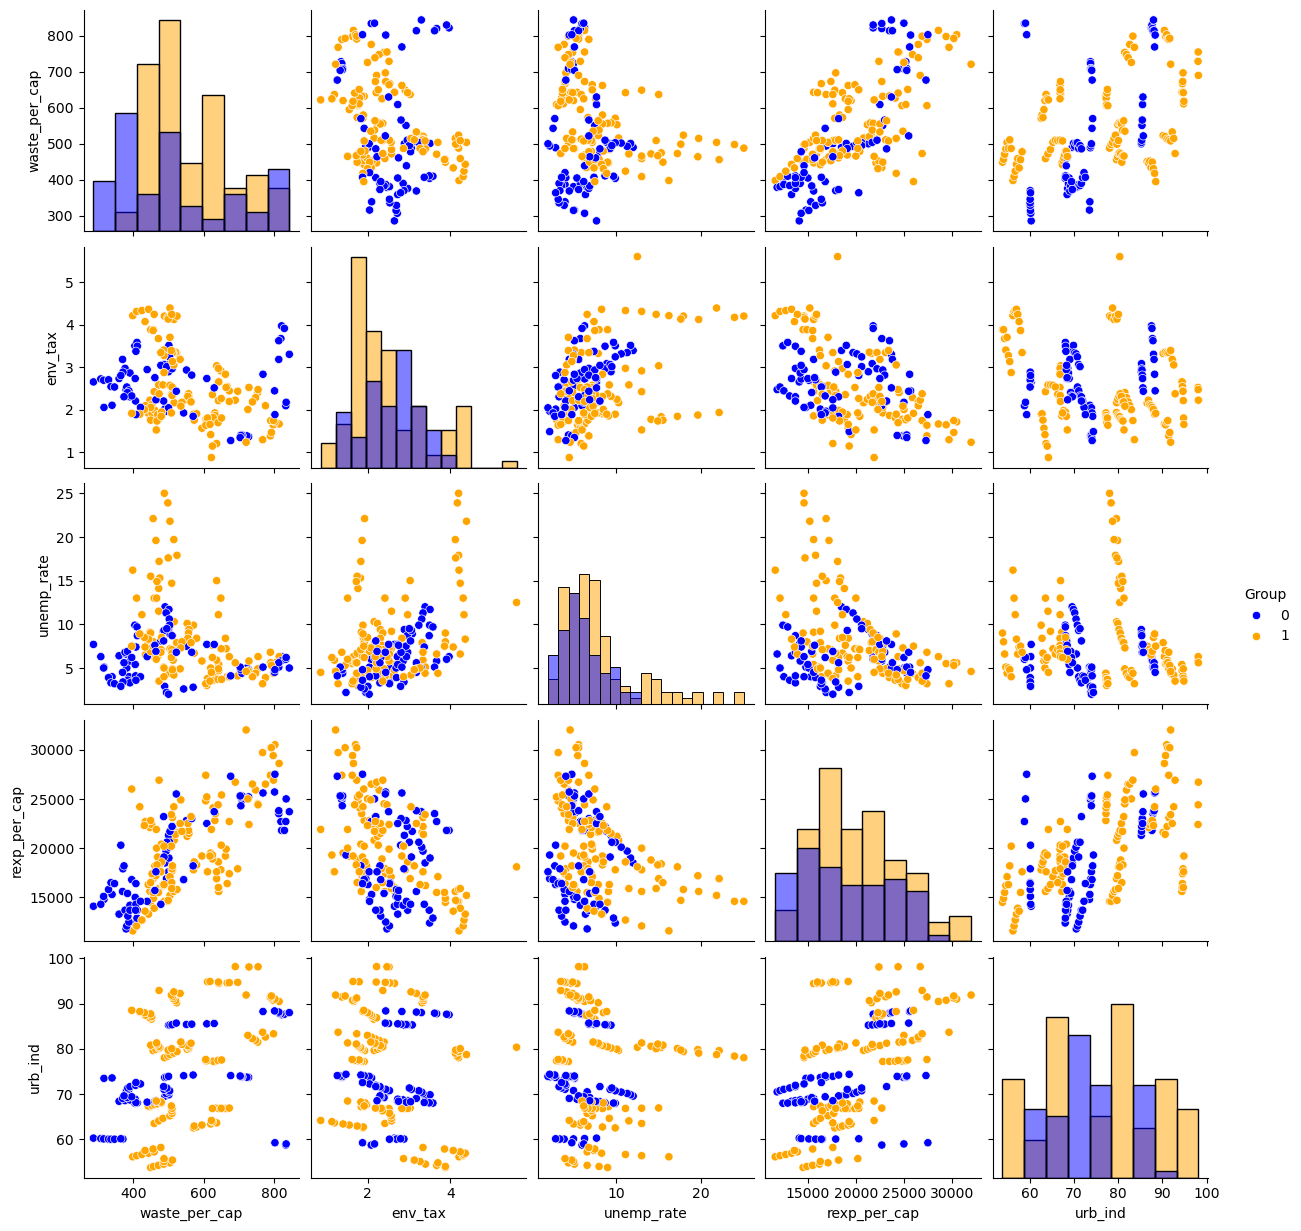

In [140]:
# 2. Correlation graphs (pairplot)

X_factors = ["env_tax", "unemp_rate", "rexp_per_cap", "urb_ind"]
sns.pairplot(df, vars=["waste_per_cap"] + X_factors, hue="Group", palette=["blue", "orange"], diag_kind='hist')
plt.show()

Before jumping in DML part it is needed to use scaling (I chose MinMax Scaler): 

### MinMax Scaler Formula:

The MinMax Scaler is used to normalize or scale data within a specific range (between 0 and 1). The formula for MinMax scaling is:

$$ 
X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

In [158]:
df_n = df.copy() 

# Select columns to be standardized
columns_to_scale = ['env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']

# Keep non-standardized columns separately
other_columns = ['Country', 'Year', 'waste_per_cap', 'Policy', 'Group']

# Standardize only the selected columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_n[columns_to_scale])

# Convert the standardized data back to a DataFrame
to_scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df_n.index)

# Combine standardized and non-standardized columns
scaled_df = pd.concat([df_n[other_columns], to_scaled_df], axis=1)
scaled_df['waste_per_cap'] = pd.to_numeric(scaled_df['waste_per_cap'], errors='coerce')

scaled_df = scaled_df.dropna()
scaled_df 



,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
0,Czechia,2015,316.0,0,0,0.249471,0.134783,0.156863,0.443884
1,Denmark,2015,822.0,0,0,0.655391,0.186957,0.500000,0.760502
2,Germany,2015,632.0,0,1,0.221987,0.104348,0.549020,0.527788
3,Estonia,2015,359.0,0,0,0.393235,0.191304,0.083333,0.329825
4,Ireland,2015,571.0,0,1,0.215645,0.343478,0.303922,0.197354
...,...,...,...,...,...,...,...,...,...
191,Slovenia,2022,487.0,1,1,0.422833,0.086957,0.421569,0.044397
192,Finland,2022,522.0,0,0,0.329810,0.208696,0.681373,0.718922
193,Sweden,2022,395.0,1,1,0.219873,0.239130,0.705882,0.782273
194,Norway,2022,768.0,1,1,0.088795,0.052174,0.887255,0.673465


After data became scaled I and can also check the covariates for multicollinearity. As we can see below, The VIF values for all covariates are low (below 2), indicating that multicollinearity is not a concern in this model.

In [148]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data_policy_scaled.xlsx"
scaled_df.to_excel(output_file, index=False)

## ML Workflow

In [165]:
# Doest Group influence waste?

ml_df = scaled_df

y = ml_df['waste_per_cap'] 
X_new = ml_df[['Group']]
X_new = sm.add_constant(X_new)
ols_model = sm.OLS(y, X_new).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.173
Date:                Sun, 12 Jan 2025   Prob (F-statistic):             0.0424
Time:                        21:55:18   Log-Likelihood:                -1225.0
No. Observations:                 194   AIC:                             2454.
Df Residuals:                     192   BIC:                             2461.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        521.3514     15.621     33.376      0.0

In [166]:
# What parameters explain waste for countries without Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 0]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 0]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     49.08
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           1.75e-19
Time:                        21:55:51   Log-Likelihood:                -432.83
No. Observations:                  74   AIC:                             875.7
Df Residuals:                      69   BIC:                             887.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          226.7727     37.184      6.099   

In [167]:
# What parameters explain waste for countries with Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 1]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 1]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     19.44
Date:                Sun, 12 Jan 2025   Prob (F-statistic):           3.04e-12
Time:                        21:56:36   Log-Likelihood:                -703.73
No. Observations:                 120   AIC:                             1417.
Df Residuals:                     115   BIC:                             1431.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          474.9274     38.261     12.413   

## DML Workflow

In [163]:
# IRM 

ml_g = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=3)

ml_m = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3)

np.random.seed(42)

obj_dml_data = dml.DoubleMLData(ml_df, 'waste_per_cap', 'Group', x_cols = ['env_tax', 'rexp_per_cap', 'urb_ind', "unemp_rate"])

dml_plr_obj = dml.DoubleMLIRM(obj_dml_data, ml_g, ml_m, n_folds = 5)

print(dml_plr_obj.fit())

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate']
Instrument variable(s): None
No. Observations: 194

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=5, min_samples_leaf=3)
Learner ml_m: RandomForestClassifier(max_depth=5, min_samples_leaf=3)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[60.32744217]]
Learner ml_g1 RMSE: [[60.06706263]]
Classification:
Learner ml_m Log Loss: [[0.22701367]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
            coef    std err         t     P>|t|     2.5 %     97.5 %
Group  25.341742  11.166284  2.269488  0.